In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
from statsmodels.tsa.stattools import acf
from scipy.special import gamma

In [2]:
dir = "figures"
os.makedirs(dir, exist_ok=True)

In [3]:
### Data loading

def load_data(filepath):

    try:
        df = pd.read_csv(filepath)
        # Check for standard Oxford Man columns
        if 'Symbol' in df.columns and 'rv5' in df.columns:
            # Clean up dates
            df['Date'] = pd.to_datetime(df['Unnamed: 0'] if 'Unnamed: 0' in df.columns else df.index, utc=True)
            df.set_index('Date', inplace=True)
            return df
        else:
            print("Columns 'Symbol' and 'rv5' exist")
            return None
    except FileNotFoundError:
        print(f"File {filepath} not found")

DATA_FILE = 'data/oxfordmanrealizedvolatilityindices.csv' 
full_data = load_data(DATA_FILE)

In [4]:
full_data.head(6)

,Unnamed: 0,Symbol,rv5_ss,close_time,rsv_ss,open_time,rk_parzen,rv5,rv10_ss,bv,close_price,rv10,open_price,rk_twoscale,medrv,bv_ss,open_to_close,nobs,rsv,rk_th2
Date,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,2000-01-03 00:00:00+00:00,.AEX,0.000130,163015.0,0.000046,90101.0,0.000179,0.000130,0.000178,0.000100,675.44,0.000178,675.67,0.000103,0.000050,0.000100,-0.000340,1795.0,0.000046,0.000102
2000-01-04 00:00:00+00:00,2000-01-04 00:00:00+00:00,.AEX,0.000201,163016.0,0.000147,90416.0,0.000423,0.000201,0.000261,0.000207,642.25,0.000261,664.20,0.000199,0.000075,0.000207,-0.033606,1785.0,0.000147,0.000201
2000-01-05 00:00:00+00:00,2000-01-05 00:00:00+00:00,.AEX,0.000491,163016.0,0.000328,90016.0,0.000324,0.000491,0.000714,0.000361,632.31,0.000714,633.37,0.000325,0.000166,0.000361,-0.001675,1801.0,0.000328,0.000345
2000-01-06 00:00:00+00:00,2000-01-06 00:00:00+00:00,.AEX,0.000225,163002.0,0.000116,90016.0,0.000219,0.000225,0.000182,0.000258,624.21,0.000182,632.46,0.000218,0.000152,0.000258,-0.013130,1799.0,0.000116,0.000221
2000-01-07 00:00:00+00:00,2000-01-07 00:00:00+00:00,.AEX,0.000138,163016.0,0.000048,90046.0,0.000155,0.000138,0.000157,0.000130,644.86,0.000157,628.93,0.000126,0.000039,0.000130,0.025013,1798.0,0.000048,0.000123
2000-01-10 00:00:00+00:00,2000-01-10 00:00:00+00:00,.AEX,0.000109,163017.0,0.000062,90146.0,0.000086,0.000109,0.000126,0.000089,655.14,0.000126,651.82,0.000074,0.000032,0.000089,0.005081,1794.0,0.000062,0.000073


In [7]:
# Filter for SPX and get Realized Variance (using rv5)
spx_data = full_data[full_data['Symbol'] == '.SPX'].copy()
# rv_col = 'rk_th2' 
rv_col = 'rv5'
spx_rk = spx_data[rv_col]

---
## RFSV Forecasting

The RFSV forecasting framework assumes that the (log-)volatility process is driven by a
**fractional Brownian motion (fBm)** with Hurst exponent $H$.

### Continuous-Time Predictor

Let $W_t^H$ denote a fractional Brownian motion.
The optimal linear predictor of $W_{t+\Delta}^H$ given the information set
$\mathcal{F}_t$ is given by:

$$
\hat{W}_{t+\Delta}^H
=
\frac{\cos(H\pi)}{\pi}
\Delta^{H+\frac{1}{2}}
\int_{-\infty}^{t}
\frac{W_s^H}
{(t-s+\Delta)(t-s)^{H+\frac{1}{2}}}
\, ds
$$

This expression highlights the **non-Markovian, long-memory nature** of rough volatility,
as the predictor depends on the entire past trajectory of the process.

### Discrete Approximation and Forecasting Weights

In practice, the integral is approximated using a Riemann sum with unit time steps.
Using midpoints

$$
s_j = t - (j + 0.5),
\quad j = 0, 1, 2, \ldots
$$

the predictor reduces to a discrete convolution:

$$
\hat{W}_{t+\Delta}^H
\;\approx\;
\sum_{j=0}^{\infty} w_j \, W_{t-j}^H
$$

with fractional weights

$$
w_j
=
\frac{1}
{(j + 0.5 + \Delta)(j + 0.5)^{H+0.5}} .
$$

In implementation, the sum is truncated at $n_{\text{lags}}$ and the weights are normalized
to form a convex combination.

### Log-Variance Forecast

Let $X_t = \log \sigma_t^2$ denote the log-variance.
The discrete RFSV forecast of future log-variance is computed as:

$$
\widehat{X}_{t+\Delta}
=
\sum_{j=0}^{n_{\text{lags}}-1}
w_j \, X_{t-j} .
$$

This corresponds to a **fractional moving average** of past log-variance observations.

### Convexity (Jensen) Correction

Since variance is obtained by exponentiating the log-variance,
a convexity correction is required:

$$
\mathbb{E}[\sigma_{t+\Delta}^2 \mid \mathcal{F}_t]
\neq
\exp\!\left( \mathbb{E}[X_{t+\Delta} \mid \mathcal{F}_t] \right).
$$

Under the RFSV model, the conditional variance of the log-variance prediction error satisfies:

$$
\mathrm{Var}(X_{t+\Delta} \mid \mathcal{F}_t)
\;\approx\;
2 \, \tilde{c}(H) \, \nu^2 \, \Delta^{2H},
$$

where $\nu$ is the volatility-of-volatility parameter and the constant
$\tilde{c}(H)$ is given explicitly by

$$
\tilde{c}(H)
=
\frac{
\Gamma\!\left(\tfrac{3}{2} - H\right)
}{
\Gamma\!\left(H + \tfrac{1}{2}\right)
\Gamma\!\left(2 - 2H\right)
}.
$$

### Final Variance Forecast

Applying the convexity correction yields the variance forecast:

$$
\boxed{
\widehat{\sigma}_{t+\Delta}^2
=
\exp\!\left(
\widehat{X}_{t+\Delta}
+
2 \tilde{c}(H) \nu^2 \Delta^{2H}
\right)
}
$$

This expression is implemented directly in the forecasting loop.

---
### Estimation of the Volatility-of-Volatility Parameter $\nu$

The parameter $\nu$ is estimated from the **scaling law of log-variance increments**.
Define the second-order moment at lag $\delta$ as

$$
m(2,\delta)
=
\mathbb{E}
\!\left[
\big(
X_{t+\delta} - X_t
\big)^2
\right].
$$

Under the RFSV model, this quantity scales as

$$
m(2,\delta)
\;\approx\;
\nu^2 \, \delta^{2H}.
$$

Taking logarithms yields the linear relation

$$
\log m(2,\delta)
=
\log(\nu^2)
+
2H \log \delta.
$$

A log–log regression of $\log m(2,\delta)$ on $\log \delta$ therefore provides:
- slope $= 2H$,
- intercept $= \log(\nu^2)$.

The volatility-of-volatility parameter is recovered as

$$
\boxed{
\nu
=
\sqrt{
\exp\!\left(
\text{intercept}
\right)
}
}
$$



In [9]:
def calculate_mq_delta(series, q, lags):
    """
    Calculates m(q, Delta) = mean( |log(sigma_{t+Delta}) - log(sigma_t)|^q )
    """
    # Volatility is sqrt(Variance)
    log_sig = np.log(np.sqrt(series)) # log(volatility) # volatility = sqrt(Realised Variance)
    
    m_q = []
    for lag in lags:
        diffs = log_sig.diff(lag).dropna()
        mean_moment = np.mean(np.abs(diffs)**q)  # averaging over time t
        m_q.append(mean_moment)
    return np.array(m_q)


In [11]:
### RFSV FORECASTING
###----

def c_tilde(h):
    return gamma(1.5 - h) / (gamma(h + 0.5) * gamma(2 - 2*h))

def forecast_rfsv(rv_series, H, nu, delta=1, n_lags=500):

    log_rv = np.log(rv_series).values
    n = len(log_rv)
    forecasts = np.full(n, np.nan)
    
    # compute weights
    ## 1 / ((j + 0.5 + delta) * (j + 0.5)^(H + 0.5))
    j = np.arange(n_lags) # j >> lags
    weights = 1.0 / ((j + 0.5 + delta) * (j + 0.5)**(H + 0.5))
    
    # Improved approximation (Riemann sum correction for first term - optional but in paper)
    # s_star = (0.5 - H)**(1 / (0.5 + H)) # Simple proxy for the gamma correction logic
    # weights[0] = 1.0 / (s_star**(H + 0.5) * (s_star + delta))
    
    # Normalize weights
    weights = weights / np.sum(weights)
    
    # Generate Forecasts
    # We start from index = n_lags
    for i in range(n_lags, n - delta):  # delta mean how many lags aheade forcast
        # Extract history and reverse it so the >> [yesterday, the day before, ...]
        history = log_rv[i - n_lags : i][::-1]
        
        # Forecast Log Vol
        log_forecast = np.dot(weights, history)
        
        # Convexity Correction for Variance Forecast
        # E[V] = exp(E[log V] + 0.5 * Var)
        # Var[log V_{t+Delta}|F_t] approx 2 * c_tilde * nu^2 * delta^(2H)
        correction = 2 * nu**2 * c_tilde(H) * (delta**(2*H))
        
        forecasts[i + delta] = np.exp(log_forecast + correction)
        
    return pd.Series(forecasts, index=rv_series.index)

# Need 'nu' (vol of vol) for the forecast correction. 
# nu is approx exp(intercept/2) from the scaling regression of m(2, delta)
# Calculate m(2, delta) again specifically for nu
lags = np.arange(1, 101)
m2_vals = calculate_mq_delta(spx_rk, 2.0, lags) # q = 2.0
slope_2, intercept_2, _, _, _ = stats.linregress(np.log(lags), np.log(m2_vals))
slope_h = slope_2/2.0
nu_est = np.sqrt(np.exp(intercept_2))
print(f"Estimated nu (vol of vol): {nu_est:.4f}")

# Run Forecast (1 day ahead)
delta_days = 1
rv_pred = forecast_rfsv(spx_rk, H=slope_h, nu=nu_est, delta=delta_days, n_lags=250)

# Comparison Data
compare_df = pd.DataFrame({
    'Actual': spx_rk,
    'Forecast': rv_pred
}).dropna()


Estimated nu (vol of vol): 0.3542


In [12]:
spx_rk.shape, rv_pred.shape

((5552,), (5552,))

In [13]:
rv_pred.head(252)

Date
2000-01-03 00:00:00+00:00         NaN
2000-01-04 00:00:00+00:00         NaN
2000-01-05 00:00:00+00:00         NaN
2000-01-06 00:00:00+00:00         NaN
2000-01-07 00:00:00+00:00         NaN
                               ...   
2000-12-26 00:00:00+00:00         NaN
2000-12-27 00:00:00+00:00         NaN
2000-12-28 00:00:00+00:00         NaN
2000-12-29 00:00:00+00:00         NaN
2001-01-02 00:00:00+00:00    0.000105
Length: 252, dtype: float64

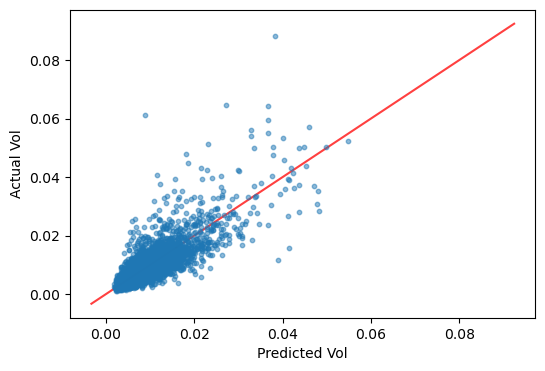

In [14]:

## --- FORECAST ---

# Actual vs Prediction Plot
plt.figure(figsize=(6,4))
plt.scatter(np.sqrt(compare_df['Forecast']), np.sqrt(compare_df['Actual']), alpha=0.5, s=10)

# x=y line
lims = [
    np.min([plt.xlim(), plt.ylim()]),  
    np.max([plt.xlim(), plt.ylim()])
]
plt.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
# plt.title('Actual vs Predicted Volatility')
plt.xlabel('Predicted Vol')
plt.ylabel('Actual Vol')
# plt.savefig("fig_8.png", dpi=200, bbox_inches='tight',
#             pad_inches=0.1, facecolor='white', edgecolor='none')
plt.show()

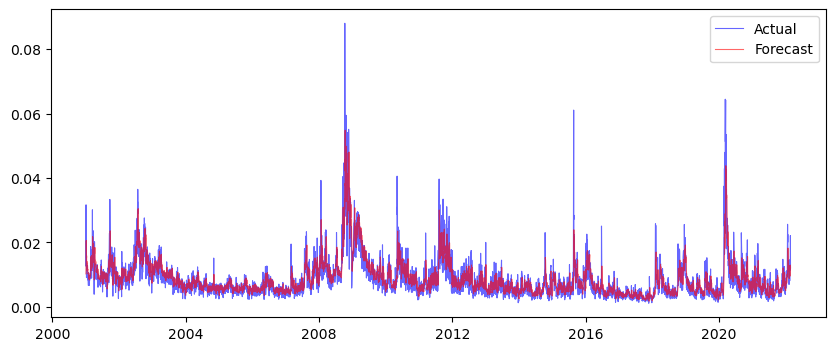

In [ ]:
# Time Series Plot
plt.figure(figsize=(10,4))
plt.plot(np.sqrt(compare_df['Actual']), label='Actual', color='blue', alpha=0.6, linewidth=0.8)
plt.plot(np.sqrt(compare_df['Forecast']), label='Forecast', color='red', alpha=0.6, linewidth=0.8)
# plt.title('Forecast vs Actual')
plt.legend()

# plt.savefig("fig_9.png", dpi=200, bbox_inches='tight',
#             pad_inches=0.1, facecolor='white', edgecolor='none')

plt.show()